In [35]:
import pandas as pd
from pathlib import Path

file_path = Path('data') / 'AavsoConcatenatedReport.txt'

# Separate header comment lines and data lines
header_lines = []
data_lines = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        if line.startswith('#'):
            header_lines.append(line.strip()[1:].strip())
        else:
            data_lines.append(line)

# Separate metadata headers and column names
# Last header line contains column names
col_line = header_lines[-1]
col_names = col_line.split(',')

# Build dictionary from header lines (excluding last line)
header_dict = {}
for hl in header_lines[:-1]:
    if '=' in hl:
        key, value = hl.split('=', 1)
        header_dict[key.strip()] = value.strip()

# Load data into DataFrame using extracted column names
from io import StringIO
df = pd.read_csv(StringIO(''.join(data_lines)), sep=',', header=None, names=col_names)
# Remove any spurious rows without a valid DATE
df = df[df['DATE'].notna()].reset_index(drop=True)

# Display results
print('Header metadata:')
print(header_dict)
print('\nDataFrame head:')
print(df.head())

Header metadata:
{'OBSCODE': 'DPEB', 'SOFTWARE': 'Phoranso 1.1.0.4', 'DELIM': ',', 'DATE': 'HJD', 'OBSTYPE': 'CCD', 'Observer': 'Peter Deeskow', 'Observer Latitude': '51 26 15.0', 'Observer Longitude': '06 49 23.1', 'Ensemble Comps': 'APASS DR10 145-1707920, APASS DR10 145-1707900, APASS DR10 145-1707636, APASS DR10 145-1708063, APASS DR10 145-1707995'}

DataFrame head:
       NAME          DATE     MAG   MERR FILT TRANS MTYPE     CNAME CMAG  \
0  TOI-3910  2.460075e+06  12.634  0.009    V    NO   STD  ENSEMBLE   na   
1  TOI-3910  2.460075e+06  12.625  0.008    V    NO   STD  ENSEMBLE   na   
2  TOI-3910  2.460075e+06  12.609  0.008    V    NO   STD  ENSEMBLE   na   
3  TOI-3910  2.460075e+06  12.585  0.008    V    NO   STD  ENSEMBLE   na   
4  TOI-3910  2.460075e+06  12.609  0.008    V    NO   STD  ENSEMBLE   na   

               KNAME    KMAG  AIRMASS GROUP  CHART  \
0  APASS 145-1707750  13.018    1.086    na    NaN   
1  APASS 145-1707750  13.015    1.083    na    NaN   
2  APASS

In [36]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation

# Parse observer latitude/longitude from metadata
def dms2deg(dms_str):
    parts = dms_str.split()
    d, m, s = map(float, parts)
    sign = 1 if d >= 0 else -1
    return sign * (abs(d) + m/60 + s/3600)

obs_lat = dms2deg(header_dict['Observer Latitude'])
obs_lon = dms2deg(header_dict['Observer Longitude'])
location = EarthLocation(lat=obs_lat * u.deg, lon=obs_lon * u.deg, height=0 * u.m)

# Prepare coordinate and time
coord = SkyCoord(ra_j2000 * u.deg, dec_j2000 * u.deg, frame='icrs')
times = Time(df['DATE'].values, format='jd', scale='utc', location=location)

# Compute light travel time and heliocentric JD
ltt = times.light_travel_time(coord)
times_helio = times + ltt
df['HJD'] = times_helio.jd

# Compute and attach delta between HJD and original JD
df['Delta_HJD'] = df['HJD'] - df['DATE']

# Show sample of heliocentric correction
print('Original JD, HJD and Delta HJD:')
print(df[['DATE','HJD','Delta_HJD']].head())

Original JD, HJD and Delta HJD:
           DATE           HJD  Delta_HJD
0  2.460075e+06  2.460075e+06   0.001353
1  2.460075e+06  2.460075e+06   0.001353
2  2.460075e+06  2.460075e+06   0.001353
3  2.460075e+06  2.460075e+06   0.001353
4  2.460075e+06  2.460075e+06   0.001353


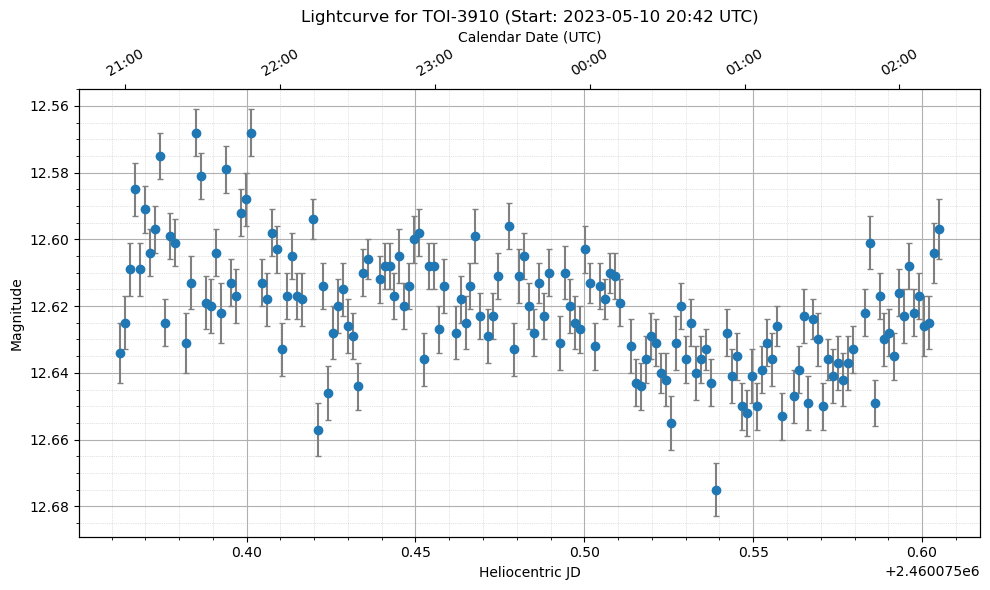

In [38]:
import matplotlib.pyplot as plt
from astropy.time import Time
import matplotlib.dates as mdates

# Convert HJD to datetime objects
times_helio = Time(df['HJD'].values, format='jd', scale='utc')
datetime_vals = times_helio.to_datetime()

# Create scatter plot with error bars
fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(df['HJD'], df['MAG'], yerr=df['MERR'], fmt='o', ecolor='gray', capsize=2, label='Observations')
ax.invert_yaxis()  # Magnitude scale inverted
ax.set_xlabel('Heliocentric JD')
ax.set_ylabel('Magnitude')
start_dt = datetime_vals.min()
ax.set_title(f"Lightcurve for {object_name} (Start: {start_dt.strftime('%Y-%m-%d %H:%M')} UTC)")
ax.grid(True)  # Primary grid
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.7)

# Twin axis: calendar date with dynamic formatting
ax2 = ax.twiny()
# Set twin x-limits to heliocentric datetime range in matplotlib date format
dt_min, dt_max = datetime_vals.min(), datetime_vals.max()
md_min, md_max = mdates.date2num(dt_min), mdates.date2num(dt_max)
ax2.set_xlim(md_min, md_max)
# Determine time span in days
span_days = df['HJD'].max() - df['HJD'].min()
if span_days < 1:
    # plot hours and minutes for short intervals
    locator = mdates.HourLocator()
    formatter = mdates.DateFormatter('%H:%M')
else:
    locator = mdates.AutoDateLocator()
    formatter = mdates.AutoDateFormatter(locator)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
plt.setp(ax2.get_xticklabels(), rotation=30)
ax2.set_xlabel('Calendar Date (UTC)')

plt.tight_layout()
plt.show()